In [430]:
import sqlite3

# Connect to the database
conn = sqlite3.connect("student_database.db")
cursor = conn.cursor()

# Create the students table if it doesn't exist
cursor.execute("""
    CREATE TABLE IF NOT EXISTS students (
        id INTEGER PRIMARY KEY,
        name TEXT,
        university TEXT
    )
""")

# Insert the data
cursor.execute("""
    INSERT INTO students (id, name, university) VALUES
    (1, 'John Doe', 'Harvard University'),
    (2, 'Jane Doe', 'Stanford University'),
    (3, 'Bob Smith', 'MIT'),
    (4, 'Alice Johnson', 'Harvard University'),
    (5, 'Mike Brown', 'Stanford University'),
    (6, 'Emily Davis', 'MIT'),
    (7, 'Tom Harris', 'Harvard University'),
    (8, 'Sophia Lee', 'Stanford University'),
    (9, 'Jackson White', 'MIT'),
    (10, 'Olivia Martin', 'Harvard University')
""")

# Commit the changes and close the connection
conn.commit()
conn.close()

In [431]:
import os
import getpass
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_groq import ChatGroq
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
import os
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain_community.llms import Ollama
from langchain.chains import RetrievalQA
from collections import defaultdict

In [432]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "pr-tart-safeguard-1"
os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

In [433]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())


In [434]:
llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [435]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    route: str
    explanation: str
    context: str
    chat_history: list
    sql_query: str  

In [436]:
graph_builder = StateGraph(State)


In [437]:
def extract_sql_query(sql_query_content):
    start_index = sql_query_content.find("SELECT")
    end_index = sql_query_content.find(";")
    if start_index != -1 and end_index != -1:
        sql_query = sql_query_content[start_index:end_index + 1]
        return sql_query.strip()
    else:
        lines = sql_query_content.splitlines()
        sql_query = ""
        for line in lines:
            if line.strip().startswith("SELECT"):
                sql_query += line.strip() + " "
            elif ";" in line:
                sql_query += line.strip()
                break
            else:
                sql_query += line.strip() + " "
        return sql_query.strip()


In [438]:
import re

In [439]:
def router(state: State) -> dict:
    latest_message = state["messages"][-1]
    user_query = latest_message.content.lower()

    decision_prompt = (
        "You are a decision-making assistant responsible for routing user queries to the appropriate processing system.\n\n"
        "Here is the user's query:\n\n"
        f"\"{user_query}\"\n\n"
        "Please analyze the query and decide the most suitable category for processing.\n\n"
        "Based on the content of the query, choose one of the following categories:\n"
        "1. **SQL**: If the query is related to the student table with attributes like id, name, university . my schema CREATE TABLE IF NOT EXISTS students id  INTEGER PRIMARY KEY,name TEXT,university TEXT as a sample some queries I share:SELECT * FROM students;SELECT * FROM students WHERE id = [id];SELECT * FROM students WHERE name = '[name]';SELECT * FROM students WHERE university = '[university]';SELECT * FROM students WHERE major = '[major]';SELECT name, age FROM students WHERE university = '[university]';SELECT university, AVG(age) as avg_age FROM students GROUP BY university;SELECT university, COUNT(*) as num_students FROM students GROUP BY university;"
        "2. **Vector**: If the query is related to RAG Retrieval-Augmented Generation or Generative Ai or NLP Tasks.\n\n"
        "3. **Wiki**: If the query is not match above context then answer wiki.\n"
        "give one word strictly not give anve answer in more than onw word"
    )

    decision_response = llm.invoke(decision_prompt)
    decision_response_text = decision_response.content.strip().lower()
    print("----------------------decision : ",decision_response_text)
    if "sql" in decision_response_text:
        while True:
            sql_query_prompt = (
                "Generate the corresponding SQL query based on the user's input.\n\n"
                f"Query: {user_query}\n\n"
                "Assuming the query is related to the students table with attributes like id, name, university.\n"
                "Please generate the SQL query in the following format:\n\n"
                "SELECT [columns] FROM students WHERE [conditions]"
            )
            sql_query_response = llm.invoke(sql_query_prompt)
            sql_query_content = sql_query_response.content.strip()
            sql_query_content = sql_query_content.replace("```", "")
            lines = sql_query_content.splitlines()
            sql_query = ""
            for line in lines:
                if line.strip().startswith("SELECT"):
                        sql_query += line.strip() + " "
                elif ";" in line:
                        sql_query += line.strip()
                        break
                else:
                        sql_query += line.strip() + " "
            if sql_query:
                state["sql_query"] = sql_query
                return {"next_node": "sql_search", "route": "sql_search", "sql_query": state}
    elif "wiki" in decision_response_text:
        return {"next_node": "wiki_search", "route": "wiki_search"}
    else:
        return {"next_node": "vector_search", "route": "vector_search"}

In [440]:
pdf_folder_path = './data/'
all_text = ""

In [441]:
for filename in os.listdir(pdf_folder_path):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_folder_path, filename)
        loader = PyMuPDFLoader(pdf_path)
        docs = loader.load()
        for doc in docs:
            all_text += doc.page_content + "\n" 

In [442]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=200)
chunks = text_splitter.split_text(all_text)
docs = [Document(page_content=chunk) for chunk in chunks]
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db2 = Chroma.from_documents(docs, embedding=embedding, persist_directory="./chroma_db/RRF")
db3 = Chroma(persist_directory="./chroma_db/RRF", embedding_function=embedding)
retriever = db3.as_retriever(search_kwargs={"k": 3})

c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [443]:
def vector_search(state: State) -> dict:
    query = state["messages"][-1].content
    results = retriever.invoke(query)
    context = " ".join([doc.page_content for doc in results])
    return {"messages": [("ai", "")], "route": state["route"], "context": context}


In [444]:
def wiki_search(state: State) -> dict:
    query = state["messages"][-1].content
    results = wikipedia.run(query)
    context = " ".join([result for result in results])
    return {"messages": [("ai", "")], "route": state["route"], "context": context}


In [445]:
def process_with_llm(state: State) -> dict:
    query = state["messages"][-2].content
    context = state["context"]
    chat_history = state.get("chat_history", []) + [("user", query)]
    prompt = f"""You are an expert assistant for answering questions accurately and in detail. 
    You must base your response strictly on the provided context and chat history. 
    If the context and chat history do not contain enough information to answer the question, respond with 'I don't know.' 
    Avoid using any information not present in the context and chat history but use related information from your knowledge. 
    Ensure your answer is clear and directly addresses the question but give answer in detail.
    Chat History:
    {chat_history}
    Context:(Context may be result from sql students table which has attributes id,name,university I give you sql query data from table explain in enhaced way like summarization in detail   and may be context from multiple doxcuments related to query and may be its wikipedia docuements)
    {context}
    Question: {query}
    Answer:"""
    response = llm.invoke(prompt)
    chat_history = state.get("chat_history", []) + [("user", query), ("ai", str(response))]
    return {"messages": [("ai", str(response))], "route": state["route"], "explanation": state["explanation"], "context": context, "chat_history": chat_history}


In [446]:
import sqlite3


In [447]:
def sql_node(state: State) -> dict:
    sql_query_dict = state.get("sql_query", "")
    
    if isinstance(sql_query_dict, dict) and 'sql_query' in sql_query_dict:
        sql_query = sql_query_dict['sql_query']
        sql_query = sql_query.split('```')[0].strip()
        sql_query = sql_query.replace("\\", "")  
        sql_query = sql_query.replace('"', '')  

        query_start = sql_query.find("SELECT")
        query_end = sql_query.find(";")
        sql_query = sql_query[query_start:query_end]
    
    if sql_query:
        conn = sqlite3.connect("student_database.db")
        cursor = conn.cursor()
        cursor.execute(sql_query)
        results = cursor.fetchall()
        conn.close()
        
        names = [row[0] for row in results]  
        context = "\n".join([", ".join(map(str, row)) for row in results])
        return {"messages": [("ai", context)], "route": state["route"], "context": context}
    else:
        return {"messages": [("ai", "No SQL query provided")], "route": state["route"], "context": state["context"]}


In [448]:
graph_builder.add_node("router", router)
graph_builder.add_node("vector_search", vector_search)
graph_builder.add_node("wiki_search", wiki_search)
graph_builder.add_node("process_with_llm", process_with_llm)
graph_builder.add_node("sql_search", sql_node)


In [449]:
def routing_condition(state: State) -> str:
    if state["route"] == "vector_search":
        return "vector_search"
    elif state["route"] == "wiki_search":
        return "wiki_search"
    elif state["route"] == "sql_search":
        return "sql_search"
    else:
        return "vector_search"

In [450]:
graph_builder.add_edge(START, "router")
graph_builder.add_conditional_edges(
    "router",
    routing_condition,
)

graph_builder.add_edge("sql_search", "process_with_llm")
graph_builder.add_edge("vector_search", "process_with_llm")
graph_builder.add_edge("wiki_search", "process_with_llm")
graph_builder.add_edge("process_with_llm", END)


In [451]:
from langgraph.checkpoint.memory import MemorySaver


In [452]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

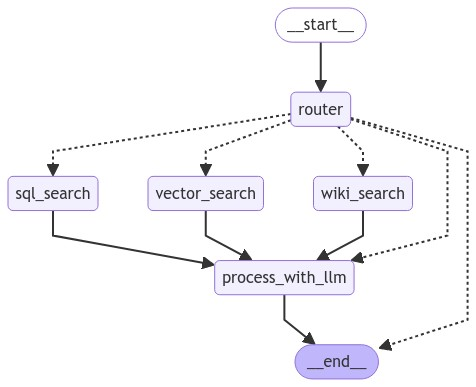

In [453]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [454]:
user_input = "give all universities of student data?"
config = {"configurable": {"thread_id": "23"}}
initial_state = {
    "messages": [{"role": "user", "content": user_input}],
    "route": "",
    "explanation": "",
    "context": "",
    "chat_history": []
}
events = graph.stream(initial_state, config, stream_mode="values")
for event in events:
    pass

print(f"Last message: {event['messages'][-1]}")

----------------------decision :  sql
Last message: content="content='Based on the information provided in the context, the universities associated with the student data are Harvard University, Stanford University, and MIT. These universities are repeated several times in the context, indicating that there may be multiple students attending each of these institutions. However, the exact number of students at each university is not provided in the context.' response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 246, 'total_tokens': 313, 'completion_time': 0.107083209, 'prompt_time': 0.042371391, 'queue_time': 0.0013320689999999982, 'total_time': 0.1494546}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None} id='run-a41fb36e-28ed-4eb8-829d-e5073c28ccdb-0' usage_metadata={'input_tokens': 246, 'output_tokens': 67, 'total_tokens': 313}" id='23938bd6-e215-4fee-99a2-d09b9cb3dada'


In [455]:
user_input = "Give names of student  who study in harvard university?"
config = {"configurable": {"thread_id": "2"}}
initial_state = {
    "messages": [{"role": "user", "content": user_input}],
    "route": "",
    "explanation": "",
    "context": "",
    "chat_history": []
}
events = graph.stream(initial_state, config, stream_mode="values")
for event in events:
    pass

print(f"Last message: {event['messages'][-1]}")

----------------------decision :  sql
Last message: content="content='Based on the information provided in the context, the students who study in Harvard University are John Doe, Alice Johnson, Tom Harris, and Olivia Martin.' response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 236, 'total_tokens': 269, 'completion_time': 0.05211887, 'prompt_time': 0.015427588, 'queue_time': 0.0007960749999999985, 'total_time': 0.067546458}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None} id='run-28c06f3b-606a-4181-ac25-4f8287e91dfa-0' usage_metadata={'input_tokens': 236, 'output_tokens': 33, 'total_tokens': 269}" id='35e21961-689b-4dd2-85ad-6267545cfee8'


In [456]:
user_input = "What is RAG in gen ai?"
config = {"configurable": {"thread_id": "23"}}
initial_state = {
    "messages": [{"role": "user", "content": user_input}],
    "route": "",
    "explanation": "",
    "context": "",
    "chat_history": []
}
events = graph.stream(initial_state, config, stream_mode="values")
for event in events:
    pass

print(f"Last message: {event['messages'][-1]}")

----------------------decision :  vector
Last message: content='content=\'RAG, which stands for Retrieval-Augmented Generation, is a model used in general artificial intelligence. It combines the generation flexibility of "closed-book" (parametric only) approaches with the performance of "open-book" retrieval-based approaches. This model enjoys strong results without the need for expensive, specialized "salient span masking" pre-training, unlike other models such as REALM and T5+SSM.\\n\\nRAG\\\'s retriever is initialized using DPR\\\'s retriever, which uses retrieval supervision on Natural Questions and TriviaQA. This means that RAG is trained to retrieve relevant information from a large dataset, similar to how a student might use a textbook to find answers to questions.\\n\\nThe RAG model contains trainable parameters for the BERT-base query and document encoder of DPR, with 110M parameters each, and 406M trainable parameters from BART-large. This makes a total of 626M trainable par

In [457]:
user_input = "who is henry?"
config = {"configurable": {"thread_id": "23"}}
initial_state = {
    "messages": [{"role": "user", "content": user_input}],
    "route": "",
    "explanation": "",
    "context": "",
    "chat_history": []
}
events = graph.stream(initial_state, config, stream_mode="values")
for event in events:
    pass

print(f"Last message: {event['messages'][-1]}")

----------------------decision :  wiki
Last message: content='content=\'Henry David Jaglom is an English-born American actor, film director, and playwright. He was born in January 1938. This information is from the page "Henry David Jaglom" that was provided in the context.\' response_metadata={\'token_usage\': {\'completion_tokens\': 53, \'prompt_tokens\': 3099, \'total_tokens\': 3152, \'completion_time\': 0.084509214, \'prompt_time\': 0.15904762, \'queue_time\': 0.0014864739999999876, \'total_time\': 0.243556834}, \'model_name\': \'mixtral-8x7b-32768\', \'system_fingerprint\': \'fp_c5f20b5bb1\', \'finish_reason\': \'stop\', \'logprobs\': None} id=\'run-52c10112-8211-46ec-a9a9-3b4bd65ae32d-0\' usage_metadata={\'input_tokens\': 3099, \'output_tokens\': 53, \'total_tokens\': 3152}' id='cda494f1-f7b7-4811-b219-914378b0a115'


In [459]:
user_input = "give all universities in which student study?"
config = {"configurable": {"thread_id": "23"}}
initial_state = {
    "messages": [{"role": "user", "content": user_input}],
    "route": "",
    "explanation": "",
    "context": "",
    "chat_history": []
}
events = graph.stream(initial_state, config, stream_mode="values")
for event in events:
    pass

print(f"Last message: {event['messages'][-1]}")

----------------------decision :  the most suitable category for processing the user's query "give all universities in which student study?" is **sql**. this query is related to retrieving information from a student table with an attribute like university.
Last message: content="content='The universities in which students study, based on the information provided in the context, are Harvard University, Stanford University, and MIT (Massachusetts Institute of Technology). These three universities are well-known and highly respected institutions of higher learning, located in Cambridge, Massachusetts (Harvard), Stanford, California (Stanford), and Cambridge, Massachusetts (MIT), respectively. Each university offers a wide range of undergraduate and graduate programs across various fields of study.' response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 222, 'total_tokens': 314, 'completion_time': 0.147312332, 'prompt_time': 0.013171244, 'queue_time': 0.00068762499999